In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from IPython.display import display, Math
from scipy.optimize import minimize
import astropy.units as u
from astropy.modeling.models import custom_model
from scipy import interpolate
import keras
from scipy.optimize import Bounds
import sys
sys.path.insert(0, '/media/carterrhea/carterrhea/SIGNALS/LUCI/')  # Location of Luci
import LUCI.LuciFit as lfit
import emcee
import corner


In [2]:
# Read in Data

sigma_info = []
velocity_info = []
res_info = []
spectrum = fits.open('../Data/Reference-Spectrum-R5000.fits')
header = spectrum[0].header
spec = spectrum[1].data
channel = []
counts = []
for chan in spec:
    channel.append(chan[0])
    counts.append(chan[1])

axis = channel
sky = counts
velocity = header['VELOCITY']
sigma = header['BROADEN']
print(velocity, sigma)

0 10


In [3]:
# Machine Learning Reference Spectrum
ref_spec = fits.open('../ML/Reference-Spectrum-R5000.fits')[1].data
channel = []
counts = []
for chan in ref_spec:  # Only want SN3 region
    channel.append(chan[0])
    counts.append(np.real(chan[1]))
min_ = np.argmin(np.abs(np.array(channel)-14700))
max_ = np.argmin(np.abs(np.array(channel)-15600))
wavenumbers_syn = channel[min_:max_]

In [4]:
f = interpolate.interp1d(axis, sky, kind='slinear')
sky_corr = (f(wavenumbers_syn))
sky_corr_scale = np.max(sky_corr)
sky_corr = sky_corr/sky_corr_scale
print(sky_corr.shape)

(460,)


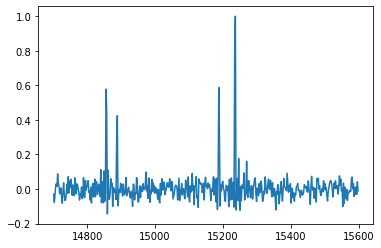

In [5]:
plt.plot(wavenumbers_syn, sky_corr)

In [6]:
fit = lfit.Fit(sky, axis, wavenumbers_syn, 'sinc', ['Halpha', 'NII6583', 'NII6548','SII6716', 'SII6731'], [1,1,1,1,1], [1,1,1,2,2],
                keras.models.load_model('../ML/R5000-PREDICTOR-I'),
                 Plot_bool = False, bayes_bool=False)
fit_dict = fit.fit()
print(fit_dict['velocities'])
print(fit_dict['fit_sol'])

[16.109225185520764, 16.10922518549084, 16.109225185472425, 16.109225185512344, 16.10922518549976]
[1.00000000e+00 1.52365805e+04 9.84344084e-01 5.87527454e-01
 1.51888809e+04 9.81262500e-01 1.60273999e-01 1.52709487e+04
 9.86564410e-01 4.23900902e-01 1.48879739e+04 9.61822707e-01
 5.77724218e-01 1.48561668e+04 9.59767839e-01]


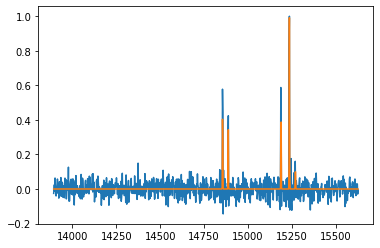

In [7]:
plt.plot(axis, sky)
plt.plot(axis, fit_dict['fit_vector'])


In [8]:
model = keras.models.load_model('../ML/R5000-PREDICTOR-I')

Spectrum = sky_corr.reshape(1, sky_corr.shape[0], 1)
print(Spectrum.shape)
predictions = model(Spectrum, training=False)
vel_ml = float(predictions[0][0])
broad_ml = float(predictions[0][1])
print(vel_ml, broad_ml)
line_halpha = 656.28
line_ml = 1e7/((vel_ml/3e5)*line_halpha + line_halpha)
print(line_ml)
# Calculate flux estimate
line_ind = np.argmin(np.abs(np.array(axis)-line_ml))
flux_est = np.max([sky[line_ind-1], sky[line_ind], sky[line_ind+1]])
print(flux_est)

(1, 460, 1)
16.110090255737305 19.381200790405273
15236.580462344045
1.0


In [9]:
A_min = 0#1e-19
A_max = 1.#1e-15
x_min = 14700
x_max = 15400
sigma_min = 0
sigma_max = 10

class Gaussian:
    def __init__(self, channel, params):
        A = params[0]; x = params[1]; sigma = params[2]
        self.func = A*np.exp((-(channel-x)**2)/(2*sigma**2))

# Update the model
def gaussian_model(channel, theta, models):
    """
    """
    f1 = 0.0
    for model_num in range(len(models)):
        params = theta[model_num*3:(model_num+1)*3]
        f1 += Gaussian(channel, params).func
    return f1


In [10]:
def log_likelihood(theta, x, y, yerr, model):
    """
    theta - list of parameters for gaussian fit
    """
    model = gaussian_model(x, theta, model)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2*np.pi*sigma2))


In [11]:
line_dict = {'Halpha': 656.280, 'NII6583': 658.341, 'NII6548': 654.803, 'SII6716': 671.647, 'SII6731': 673.085}
def line_vals_estimate(spec, line_name):
    line_theo = line_dict[line_name]
    line_pos_est = 1e7/((vel_ml/3e5)*line_theo + line_theo)  # Estimate of position of line in cm-1
    line_ind = np.argmin(np.abs(np.array(axis)-line_pos_est))
    line_amp_est = np.max([sky[line_ind-2], sky[line_ind-1], sky[line_ind], sky[line_ind+1], sky[line_ind+2]])
    line_broad_est = (line_pos_est*2.355*broad_ml)/3e5
    return line_amp_est, line_pos_est, line_broad_est
    
model = ['Halpha']
nll = lambda *args: -log_likelihood(*args)
initial = np.ones((3*len(model)))
sky_scale = np.max(sky)
sky_norm = sky/sky_scale
bounds_ = []
for mod in range(len(model)):
    val = 3*mod + 1
    amp_est, vel_est, sigma_est = line_vals_estimate(sky_norm, model[mod])
    initial[3*mod] = amp_est
    initial[3*mod + 1] = vel_est
    initial[3*mod + 2] = sigma_est
    bounds_.append((A_min, A_max))
    bounds_.append((x_min, x_max))
    bounds_.append((sigma_min, sigma_max))
bounds_l = [val[0] for val in bounds_]
bounds_u = [val[1] for val in bounds_]
bounds = Bounds(bounds_l, bounds_u)

def fun_der(theta, axis, y, yerr, model):
    return Jacobian(lambda theta: log_likelihood(theta, axis, y, yerr, model))(theta).ravel()

soln = minimize(nll, initial, method='SLSQP',# jac=fun_der,
                options={'disp': True}, bounds=bounds, tol=1e-8,
                args=(axis, sky_norm, 1e-2, model))
init_var = soln.x
line_fit = 1e7/((init_var[1]/3e5)*line_halpha + line_halpha)
print(init_var)
print(3e5*((1e7/init_var[1] - 656.28)/(1e7/init_var[1])))
print(3e5*init_var[2]/init_var[1])


Optimization terminated successfully    (Exit mode 0)
            Current function value: 15068.248046875
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
[1.00000000e+00 1.52365805e+04 2.31813032e+00]
16.109225185520764
45.64272786140442


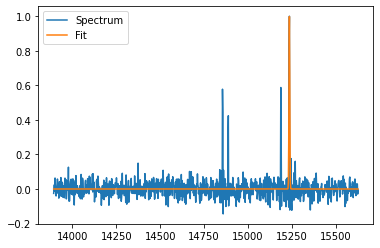

Calculated velocity: 16.11 km/s


In [12]:
#if model == 1:
parameters = soln.x

final_model = gaussian_model(axis, parameters, model)
plt.clf()
plt.plot(axis, sky, label='Spectrum')
plt.plot(axis, final_model, label='Fit')
plt.legend()
plt.show()
l_calc = 1e7/parameters[1]  # Halpha
#print(l_calc)
l_shift = (l_calc - 656.28)/l_calc
#print(l_shift)
v = 3e5*l_shift
print("Calculated velocity: %.2f km/s"%v)

In [13]:
def log_prior(theta, model):
    for model_num in range(len(model)):
        params = theta[model_num*3:(model_num+1)*3]
    within_bounds = True  # Boolean to determine if parameters are within bounds
    for ct, param in enumerate(params):
        if ct%3 == 0:  # Amplitude parameter
            if param > A_min and param < A_max:
                pass
            else:
                within_bounds = False  # Value not in bounds
                break
        if ct%3 == 1:  # velocity parameter
            if param > x_min and param < x_max:
                pass
            else:
                within_bounds = False  # Value not in bounds
                break
        if ct%3 == 2:  # sigma parameter
            if param > sigma_min and param < sigma_max:
                pass
            else:
                within_bounds = False  # Value not in bounds
                break
    if within_bounds:
        return 0.0
    else:
        return -np.inf
    #A_,x_,sigma_ = theta
    #if A_min < A_ < A_max and x_min < x_ < x_max and sigma_min < sigma_ < sigma_max:
    #    return 0.0#np.log(1/((t_max-t_min)*(rp_max-rp_min)*(b_max-b_min)))
    #return -np.inf



In [14]:
def log_probability(theta, x, y, yerr, model):
    lp = log_prior(theta, model)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr, model)

In [15]:
n_dim = 3 * len(model)
n_walkers = 100

init_ = init_var + 1 * np.random.randn(n_walkers, n_dim)

sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=(axis, sky_norm, 1e-2, model))
sampler.run_mcmc(init_, 2000, progress=True);

100%|██████████| 2000/2000 [00:20<00:00, 98.20it/s] 


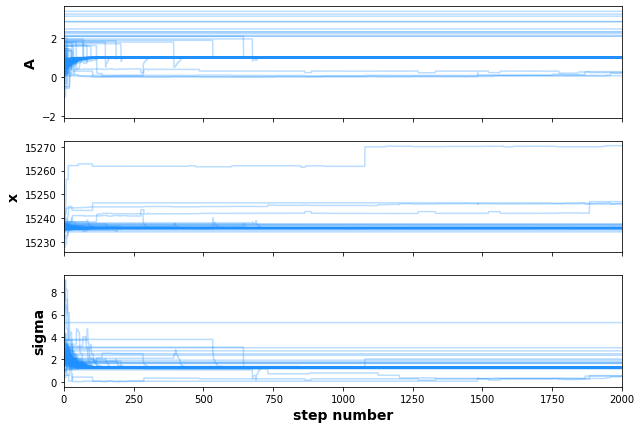

In [16]:
fig, axes = plt.subplots(n_dim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
if len(model) == 1:
    labels = [r"A", r"x", "sigma"]
elif len(model) == 2:
    labels = [r"A", r"x", r"\sigma", r"A_2", r"x_2", r"\sigma_2"]
elif len(model) == 3:
    labels = [r"A", r"x", r"\sigma", r"A_2", r"x_2", r"\sigma_2", r"A_3", r"x_3", r"\sigma_3"]
elif len(model) == 4:
    labels = [r"A", r"x", r"\sigma", r"A_2", r"x_2", r"\sigma_2", r"A_3", r"x_3", r"\sigma_3", r"A_4", r"x_4", r"\sigma_4"]
elif len(model) == 5:
    labels = [r"A", r"x", r"\sigma", r"A_2", r"x_2", r"\sigma_2", r"A_3", r"x_3", r"\sigma_3", r"A_4", r"x_4", r"\sigma_4", r"A_5", r"x_5", r"\sigma_5"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", color='dodgerblue', alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontweight='bold', fontsize=14)
    #ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number", fontsize=14, fontweight='bold');
plt.savefig('Emcee-steps.png')

In [17]:
flat_samples = sampler.get_chain(discard=200, flat=True)
parameters = []
for i in range(n_dim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    parameters.append(mcmc[1])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[]

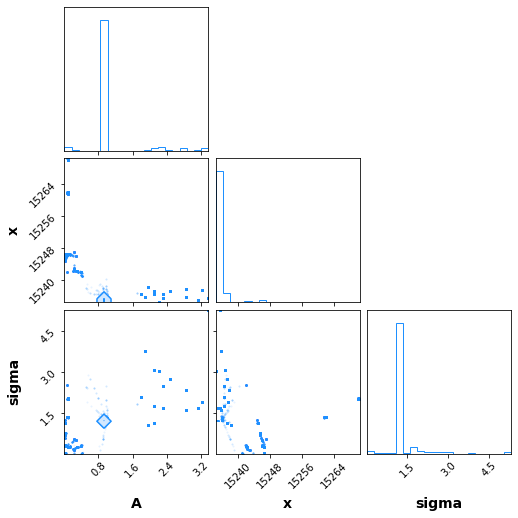

In [18]:
fig = corner.corner(
    flat_samples, labels=labels, color='dodgerblue', label_kwargs=dict(fontweight='bold', fontsize=14), fill_contours=True#, truths=[m_true, b_true, np.log(f_true)]
);
plt.plot()


[0.9997298536206612, 15235.869978838442, 1.276127470505594]


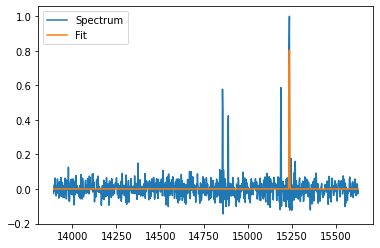

In [19]:
#if model == 1:
print(parameters)
#if model == 2:
    #parameters = [mean_[0], mean_[1],  mean_[2], mean_[3], mean_[4], mean_[5]]
final_model = gaussian_model(axis, parameters, model)
plt.clf()
plt.plot(axis, sky_norm, label='Spectrum')
plt.plot(axis, final_model, label='Fit')
plt.legend()

In [20]:
l_calc = 1e7/parameters[1]  # Halpha
#print(l_calc)
l_shift = (l_calc - 656.28)/l_calc
#print(l_shift)
v = 3e5*l_shift
print("Calculated velocity: %.2f km/s"%v)

Calculated velocity: 30.10 km/s


In [21]:
parameters[2]*3e5/(parameters[1])

25.127429000340232